### Learning Human-Like Tonal Inflections for Humanoid Robotics  
Model architecture adpated from [https://github.com/adhishthite/sound-mnist](https://github.com/adhishthite/sound-mnist)

Mandarin Tone processing adapted from [https://github.com/alicex2020/Mandarin-Tone-Classification](https://github.com/alicex2020/Mandarin-Tone-Classification)

## **Import Packages**

In [1]:
import numpy as np 
import matplotlib
import math
import os
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import IPython.display as ipd
import keras
import librosa
import librosa.display
#!pip install natsort
from natsort import os_sorted

import warnings
warnings.filterwarnings('ignore')

## **Load Train and Test Data**
Human audio files sourced from Tone Perfect: [https://tone.lib.msu.edu/](https://tone.lib.msu.edu/)

In [56]:
file_path1 = 'C:/Users/charl/OneDrive/Desktop/CMU Sem. 01/ML/Project/Tone Perfect/tone_perfect'
file_path2 = 'C:/Users/charl/OneDrive/Desktop/CMU Sem. 01/ML/Project/Tone Perfect/tone_robot_new/NewRobotLong'

def mp3tomfcc(file_path, max_pad=60):  
  audio, sample_rate = librosa.core.load(file_path) # returns audio time series and sampling rate 
  mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
  pad_width = max_pad - mfcc.shape[1]
  mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
  return mfcc

def wav2mfcc(file_path, max_pad=60):
    audio, sample_rate = librosa.core.load(file_path)
    audio[:int(0.25 * sample_rate)] = 0 # ~0.25s fade in (assumes 3 second wav file)
    audio[:int(2.75 * sample_rate)] = 0 # ~0.25s fade out
    audio = audio[::3] 
    audio = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps = -20, bins_per_octave=12) # pitch down (12 steps per octive)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    pad_width = max_pad - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

In [57]:
# load data from Tone Perfect
mfccs_human = []
counter = 0
for f in os.listdir(file_path1):
  if (f.endswith('.mp3')) and (counter < 4500):
    mfccs_human.append(mp3tomfcc(file_path1 + '/' + f, 60)) 
    counter += 1 

mfccs_h = np.asarray(mfccs_human)
print(f'mfccs_human.shape: {mfccs_h.shape}')

mfccs_human.shape: (4500, 60, 60)


In [58]:
# load data from robot
mfccs_robot = []
counter = 0  
for f in os_sorted(os.listdir(file_path2)): # natural sorting 
  if (f.endswith('.wav')) and (counter < 10000): # arbitrary large counter number if using whole dataset 
    mfccs_robot.append(wav2mfcc(file_path2 + '/' + f, 60))
    counter += 1

mfccs_r = np.asarray(mfccs_robot)
print(f'mfccs_robot.shape: {mfccs_r.shape}')

mfccs_robot.shape: (1120, 60, 60)


In [59]:
# Save MFCC's 
np.save('mfccs_half_human.npy', mfccs_human)
np.save('mfccs_robot.npy', mfccs_robot)

In [60]:
# Load MFCC's from saved files
mfccs_human = np.load('mfccs_half_human.npy').tolist()
mfccs_human = np.asarray(mfccs_human)

mfccs_robot = np.load('mfccs_robot.npy').tolist()
mfccs_robot = np.asarray(mfccs_robot)

print(f'mfccs_human.shape: {mfccs_human.shape}')
print(f'mfccs_robot.shape: {mfccs_robot.shape}')

mfccs_human.shape: (4500, 60, 60)
mfccs_robot.shape: (1120, 60, 60)


## **Load Labels**

In [61]:
# Gather all labels for male and female speakers (1-4 for each of the four tones)
labels_human = []
counter = 0
for f in os.listdir(file_path1):
  if (f.endswith('.mp3')) and (counter < 4500):    
    label = f.split('_')[0][-1] # label is the last character before the first '_'
    labels_human.append(label)
    counter += 1

labels_human = np.array(labels_human)
print(f"# of files for Class 1: {(np.where(labels_human == '1')[0].size)}")
print(f"# of files for Class 2: {(np.where(labels_human == '2')[0].size)}")
print(f"# of files for Class 3: {(np.where(labels_human == '3')[0].size)}")
print(f"# of files for Class 4: {(np.where(labels_human == '4')[0].size)}")

labels_human = keras.utils.to_categorical(labels_human, num_classes=None) # one-hot encoding 

# of files for Class 1: 1128
# of files for Class 2: 1128
# of files for Class 3: 1122
# of files for Class 4: 1122


In [62]:
# Gather all labels for robot
labels_robot = []
counter = 0
labels_robot_arr = np.loadtxt("labels.csv", delimiter=",", dtype=str)
for i in range(0, labels_robot_arr.size):
    if labels_robot_arr[i] == 'HighLevel': # high level tone 
        labels_robot.append('1')
    elif labels_robot_arr[i] == 'Rise':
        labels_robot.append('2')
    elif labels_robot_arr[i] == 'Dip':
        labels_robot.append('3')
    elif labels_robot_arr[i] == 'Fall':
        labels_robot.append('4')
    else:
        labels_robot.append('5') # will remove and ignore any file not labeled as one of the above tones 

labels_robot = np.array(labels_robot)
print(f"# of files for Class 1: {(np.where(labels_robot == '1')[0].size)}")
print(f"# of files for Class 2: {(np.where(labels_robot == '2')[0].size)}")
print(f"# of files for Class 3: {(np.where(labels_robot == '3')[0].size)}")
print(f"# of files for Class 4: {(np.where(labels_robot == '4')[0].size)}")
print(f"# of files for Class 5: {(np.where(labels_robot == '5')[0].size)}")

labels_robot = keras.utils.to_categorical(labels_robot, num_classes=None) # one-hot encoding

# of files for Class 1: 280
# of files for Class 2: 280
# of files for Class 3: 280
# of files for Class 4: 280
# of files for Class 5: 0


In [63]:
print(f"Human Voice Label Vector Shape: {labels_human.shape}")
print(f"Human Voice Label Vector Preview:\n{labels_human[:5,:]}\n\n")

print(f"Robot Voice Label Vector Shape: {labels_robot.shape}")
print(f"Robot Voice Label Vector Preview:\n{labels_robot[:5,:]}")

Human Voice Label Vector Shape: (4500, 5)
Human Voice Label Vector Preview:
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


Robot Voice Label Vector Shape: (1120, 5)
Robot Voice Label Vector Preview:
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [64]:
# save labels 
np.save('labels_half_human.npy', labels_human)
np.save('labels_robot.npy', labels_robot)

In [65]:
# load labels 
labels_human = np.load('labels_half_human.npy')
labels_robot = np.load('labels_robot.npy')

## **Build Model**

In [66]:
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical

def get_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4)) # taking care of generalization 
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,  
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

## **Training and Testing** 

In [456]:
#sklearn train_test_split used only if training and testing on either all human voice or robot audio files
"""
dim_1 = mfccs_human.shape[1]
dim_2 = mfccs_human.shape[2]
channels = 1
classes = 5

X = mfccs_human
print(X.shape)
X = X.reshape((mfccs_human.shape[0], dim_1, dim_2, channels))
print(X.shape)
y = labels_human
input_shape = (dim_1, dim_2, channels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
"""


(4500, 60, 60)
(4500, 60, 60, 1)
(3600, 60, 60, 1)


In [67]:
# Define X_train and y_train as human audio files  
 
dim_1 = mfccs_human.shape[1]
dim_2 = mfccs_human.shape[2]
channels = 1
classes = 5

X_train = mfccs_human
print(f'X_train.shape: {X_train.shape}')
X_train = X_train.reshape((mfccs_human.shape[0], dim_1, dim_2, channels))
print(f'X_train.shape (reshaped): {X_train.shape}')
y_train = labels_human
input_shape = (dim_1, dim_2, channels)

print(f'y_train.shape: {y_train.shape}')


X_train.shape: (4500, 60, 60)
X_train.shape (reshaped): (4500, 60, 60, 1)
y_train.shape: (4500, 5)


In [22]:
 
# dealing with unequal class sizes 
"""
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_train]

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_ints), y=y_ints)
class_weights_dict = dict(zip(np.unique(y_ints), class_weights))

history = model.fit(X_train, y_train, batch_size=20, epochs=15, verbose=1, validation_split=0.2, class_weight=class_weight_dict)
"""

"\nfrom sklearn.utils import class_weight\ny_ints = [y.argmax() for y in y_train]\n\nclass_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_ints), y=y_ints)\nclass_weights_dict = dict(zip(np.unique(y_ints), class_weights))\n\nhistory = model.fit(X_train, y_train, batch_size=20, epochs=15, verbose=1, validation_split=0.2, class_weight=class_weight_dict)\n"

In [68]:
model = get_cnn_model(input_shape, classes)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 59, 59, 32)        160       
                                                                 
 batch_normalization_3 (Batc  (None, 59, 59, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 58, 48)        6192      
                                                                 
 batch_normalization_4 (Batc  (None, 58, 58, 48)       192       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 120)       23160     
                                                                 
 batch_normalization_5 (Batc  (None, 57, 57, 120)     

In [50]:
# train 
history = model.fit(X_train, y_train, batch_size=20, epochs=30, verbose=1, validation_split=0.2) 

Epoch 1/20
180/180 [==============================] - 36s 199ms/step - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.0308 - val_accuracy: 0.9933
Epoch 2/20
180/180 [==============================] - 43s 238ms/step - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.0037 - val_accuracy: 0.9978
Epoch 3/20
180/180 [==============================] - 42s 236ms/step - loss: 0.0114 - accuracy: 0.9972 - val_loss: 0.0404 - val_accuracy: 0.9967
Epoch 4/20
180/180 [==============================] - 41s 230ms/step - loss: 0.0243 - accuracy: 0.9969 - val_loss: 0.0107 - val_accuracy: 0.9989
Epoch 5/20
180/180 [==============================] - 39s 218ms/step - loss: 0.0112 - accuracy: 0.9972 - val_loss: 0.0128 - val_accuracy: 0.9978
Epoch 6/20
180/180 [==============================] - 40s 225ms/step - loss: 0.0083 - accuracy: 0.9972 - val_loss: 0.0172 - val_accuracy: 0.9978
Epoch 7/20
180/180 [==============================] - 41s 226ms/step - loss: 0.0149 - accuracy: 0.9975 - val_loss: 0.0340 - val_ac

## **Evaluation of Model Performance**

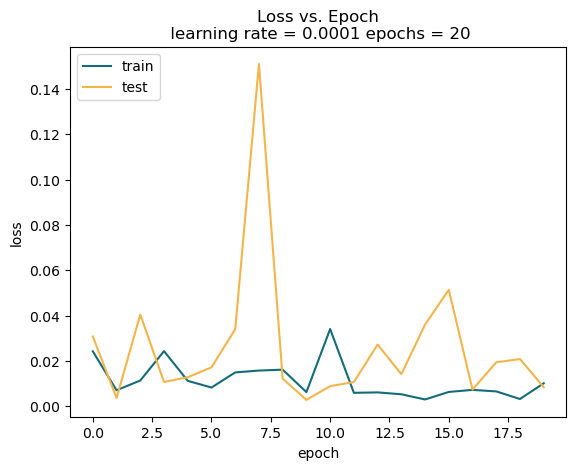

In [52]:
plt.plot(history.history['loss'], color='#146C78')
plt.plot(history.history['val_loss'], color='#f3b54a')
plt.title('Loss vs. Epoch\n learning rate = 0.0001 epochs = 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# Define X_test and y_test manually 

dim_1 = mfccs_robot.shape[1]
dim_2 = mfccs_robot.shape[2]
channels = 1
classes = 5

X_test = mfccs_robot
print(f'X_test.shape: {X_test.shape}')
X_test = X_test.reshape((mfccs_robot.shape[0], dim_1, dim_2, channels))
print(f'X_test.shape (rehsaped): {X_test.shape}')
y_test = labels_robot

print(f'y_test.shape: {y_test.shape}')


X_test.shape: (1120, 60, 60)
X_test.shape (rehsaped): (1120, 60, 60, 1)
y_test.shape: (1120, 5)


In [53]:
# evaluate model
test_metrics = model.evaluate(X_test, y_test, batch_size = 3, verbose = 1)

374/374 [==============================] - 7s 18ms/step - loss: 21.1003 - accuracy: 0.2607


In [42]:
# evaluate model on training
model.evaluate(X_train, y_train, batch_size = 3, verbose = 1)

1500/1500 [==============================] - 22s 14ms/step - loss: 4.7926e-04 - accuracy: 0.9998


[0.0004792598192580044, 0.9997777938842773]

In [54]:
# Evaluation metrics from scikit learn
import sklearn.metrics as metrics

y_pred = model.predict(X_test).ravel()
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

y_true_labels = np.argmax(y_test, axis=1)

#confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
#print(confusion_matrix)

35/35 [==============================] - 2s 56ms/step


In [202]:
# finding high probability classes
print(f'Sum of first row probabilities: {np.sum(y_pred_ohe[0,:])}')
print(f'Sum of second row probabilities: {np.sum(y_pred_ohe[1,:])}')
print(f'y_pred.shape: {y_pred_ohe.shape}')

y_true_labels[np.where(y_pred_ohe > 0.98)[0]] == y_pred_labels[np.where(y_pred_ohe > 0.98)[0]]
np.where(y_pred_ohe > 0.98)[0]
y_pred_labels[611]

Sum of first row probabilities: 0.9999999403953552
Sum of second row probabilities: 0.9999998807907104
y_pred.shape: (703, 5)


3

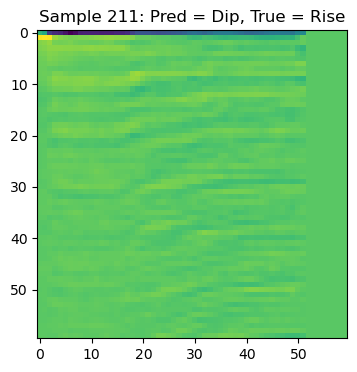

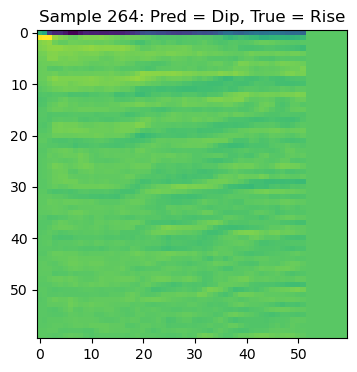

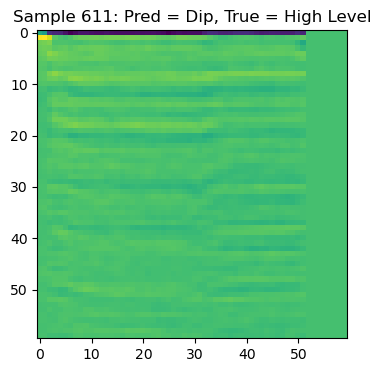

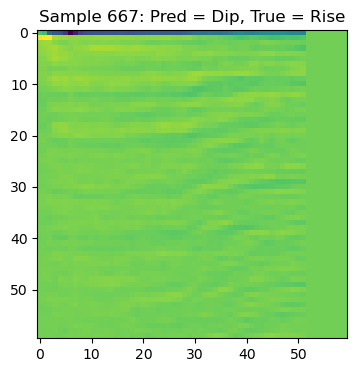

In [204]:
plt.figure(figsize=(4, 4))
plt.imshow(mfccs_robot[211,:,:], aspect='auto')#, cmap=cm.viridis)
plt.title('Sample 211: Pred = Dip, True = Rise')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(mfccs_robot[264,:,:], aspect='auto')#, cmap=cm.viridis)
plt.title('Sample 264: Pred = Dip, True = Rise')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(mfccs_robot[611,:,:], aspect='auto')#, cmap=cm.viridis)
plt.title('Sample 611: Pred = Dip, True = High Level')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(mfccs_robot[667,:,:], aspect='auto')#, cmap=cm.viridis)
plt.title('Sample 667: Pred = Dip, True = Rise')
plt.show()

35/35 [==============================] - 2s 59ms/step
Confusion matrix, without normalization
[[ 51   5 224   0]
 [ 46   0 234   0]
 [ 38   1 241   0]
 [ 61   0 219   0]]


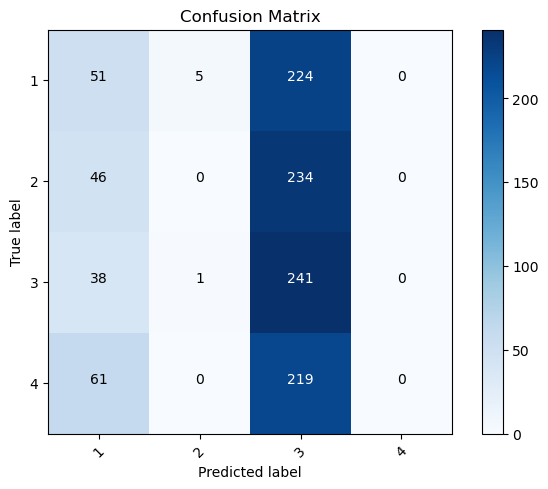

In [55]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test).ravel()

y_true_labels = np.argmax(y_test, axis=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true_labels, y_pred_labels)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[1, 2, 3, 4],
                      title='Confusion Matrix')

In [95]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'acc'